In [1]:
import numpy as np
import scipy.stats
import pylab as plt
from matplotlib import pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import random
import math

In [2]:
!pip install emcee
import emcee

!pip install corner
import corner

!pip install dynesty
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

First, we define the models and their respective likelihoods and priors.

In [3]:
# p = [b,A,t0,ln(alpha)]  parameters vector

def model_1(p,x):  #model for the burst
    array = np.full_like(x,1)
    array[x<p[2]] = p[0]
    array[x>=p[2]] = p[0]+p[1]*np.exp(-np.exp(p[3])*(x[x>=p[2]]-p[2]))
    return array

def log_likelihood_1(p,x,y,yerr):  #likelihood = prod(exp(-(y-model**2)/sigma**2)/(2*pi*sigma**2))
    return -0.5*np.sum((y-model_1(p,x))**2/yerr**2+np.log(2*np.pi*yerr**2))

def prior_1(p):
    prior_b = 50*p[0] #uniform distribution [0,50]
    prior_A = 50*p[1] #uniform distribution [0,50]
    prior_t0 = 100*p[2] #uniform distribution [0,100]
    prior_lnalpha = 5*(2*p[3]-1)  #ln(alpha) uniform distribution [-5,5]
    return [prior_b,prior_A,prior_t0,prior_lnalpha]

# p = [b,A,t0,ln(sigma)]  parameters vector

def model_2(p,x):
    return p[0]+p[1]*np.exp(-(x-p[2])**2/2/np.exp(p[3])**2)

def log_likelihood_2(p,x,y,yerr):  #likelihood = prod(exp(-(y-model**2)/sigma**2)/(2*pi*sigma**2))
    return -0.5*np.sum((y-model_2(p,x))**2/yerr**2+np.log(2*np.pi*yerr**2))

def prior_2(p):
    prior_b = 50*p[0] #uniform distribution [0,50]
    prior_A = 50*p[1] #uniform distribution [0,50]
    prior_t0 = 100*p[2] #uniform distribution [0,100]
    prior_lnsigma = 5*(2*p[3]-1)  #ln(sigma) uniform distribution [-5,5]
    return [prior_b,prior_A,prior_t0,prior_lnsigma]

Then we load and plot our data.

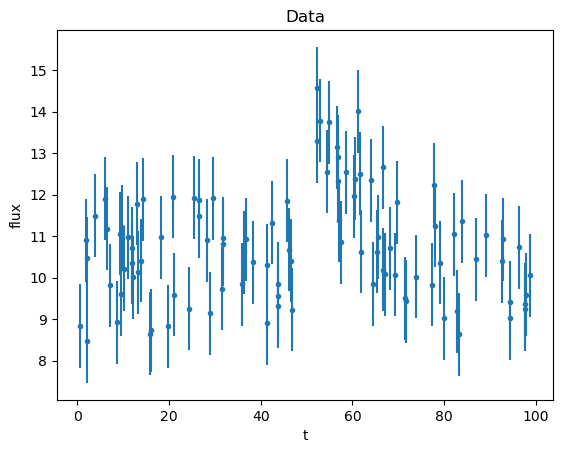

In [4]:
data = np.load('transient.npy')
plt.errorbar(data[:,0],data[:,1],data[:,2],fmt='.')
plt.xlabel('t')
plt.ylabel('flux')
plt.title('Data')
plt.show()

Now, we use nested sampling to estimate the four parameters. Then, we compute the median of each sample: these will be the estimated true values of the parameters that we will use to fit our data. We need to be carefull: the samples we obtain are weighted, therefore we need to reweight them first. We follow the same procedure for both models.

## Model 1: burst

In [5]:
# "Static" nested sampling.
ndim = 4
sampler = dynesty.NestedSampler(log_likelihood_1, prior_1, ndim=ndim, logl_args=[data[:,0],data[:,1],data[:,2]])
sampler.run_nested()
sresults = sampler.results

2909it [00:06, 96.34it/s, bound: 15 | nc: 170 | ncall: 28295 | eff(%): 10.281 | loglstar:   -inf < -180.295 <    inf | logz: -187.273 +/-  0.110 | dlogz: 34.491 >  0.509] C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
7627it [00:41, 184.41it/s, +500 | bound: 134 | nc: 1 | ncall: 117577 | eff(%):  6.942 | loglstar:   -inf < -140.658 <    inf | logz: -155.119 +/-  0.167 | dlogz:  0.001 >  0.509]


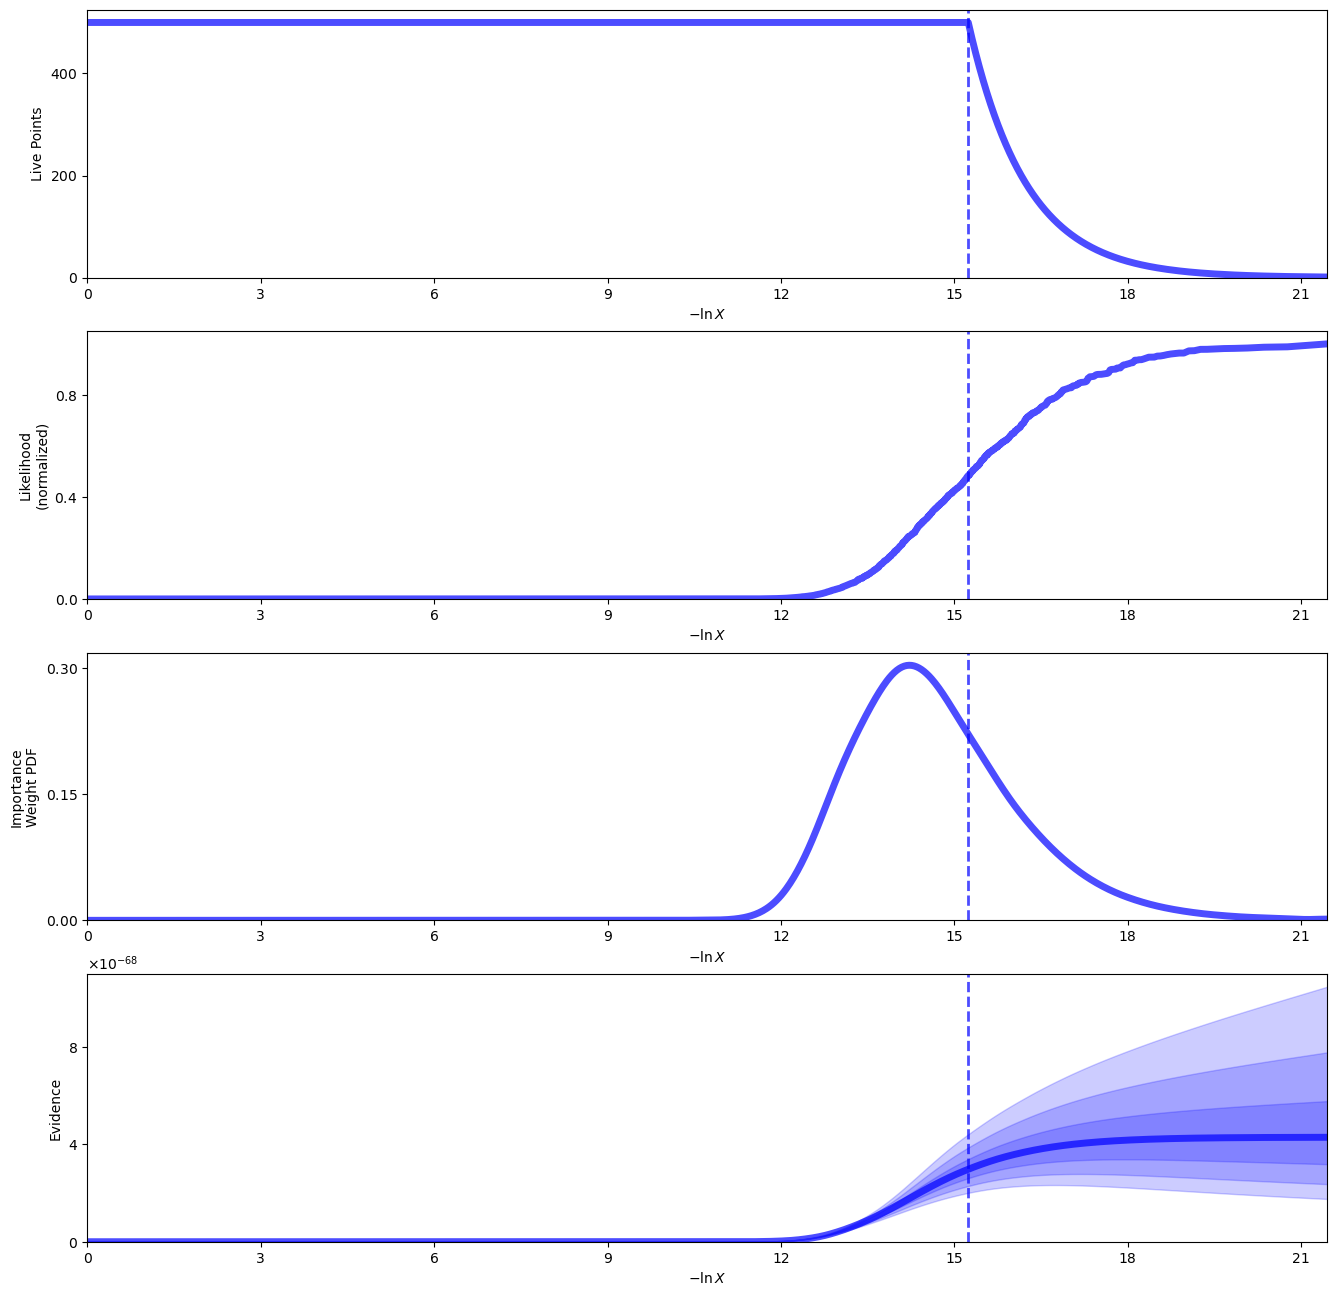

In [6]:
rfig, raxes = dyplot.runplot(sresults)

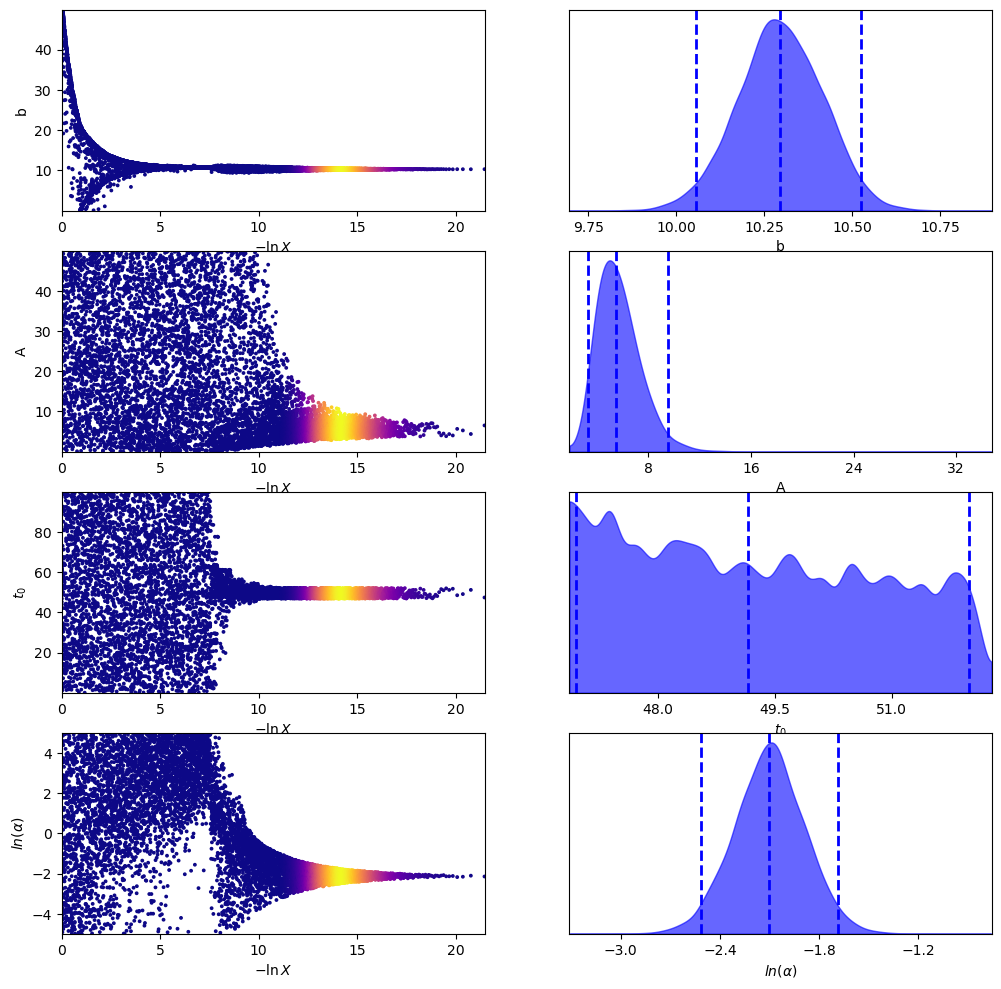

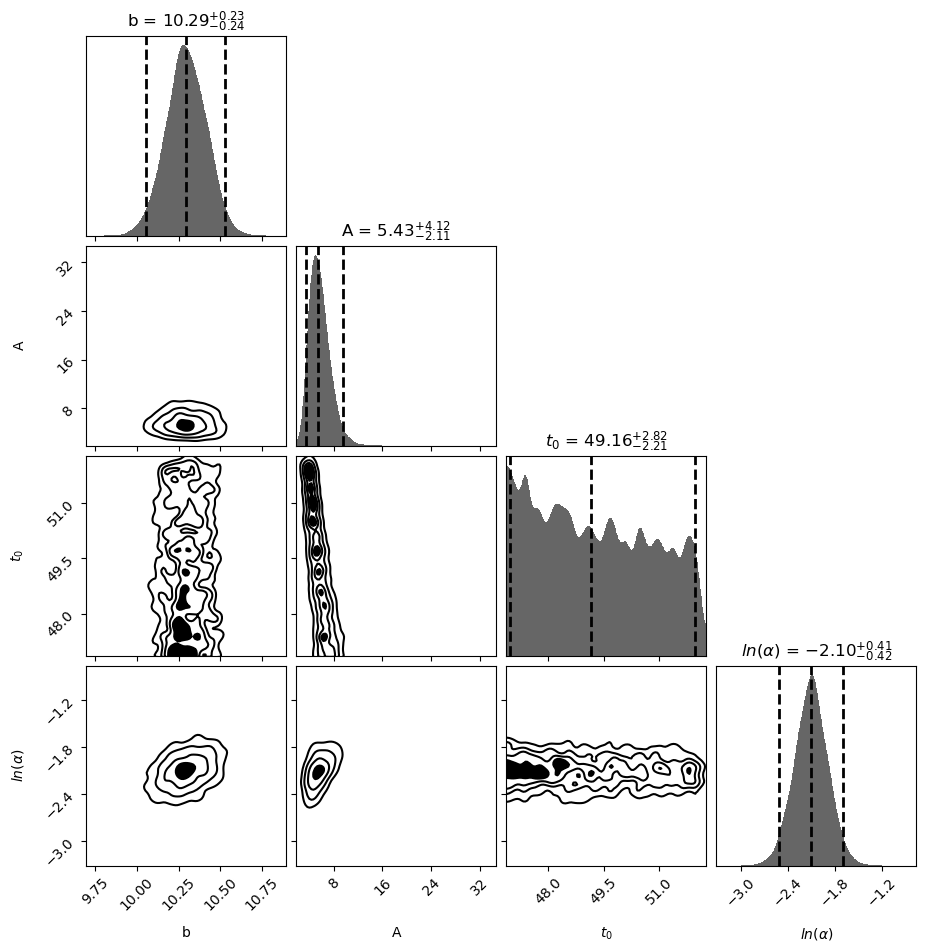

In [18]:
labels = ['b','A',r"$t_0$",r"$ln(\alpha)$"]
tfig, taxes = dyplot.traceplot(sresults,labels=labels)
cfig, caxes = dyplot.cornerplot(sresults,show_titles=True, labels=labels)

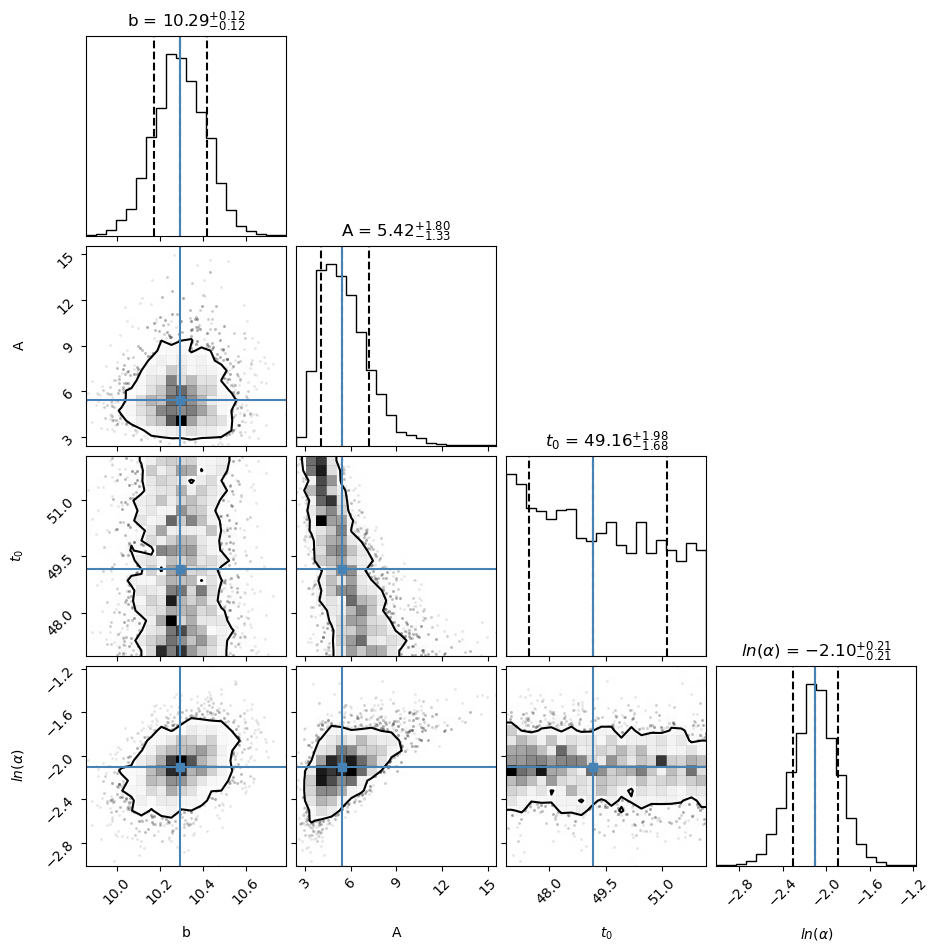

In [19]:
weights = np.exp(sresults.logwt - sresults.logz[-1])
samples = sresults.samples
samples_equal = dyfunc.resample_equal(samples, weights) #Resample weighted samples

medians = np.median(samples_equal,0)
fig = corner.corner(samples_equal, levels=[0.9],labels=labels,
                    truths=medians,show_titles=True,quantiles=[0.16,0.5,0.84])

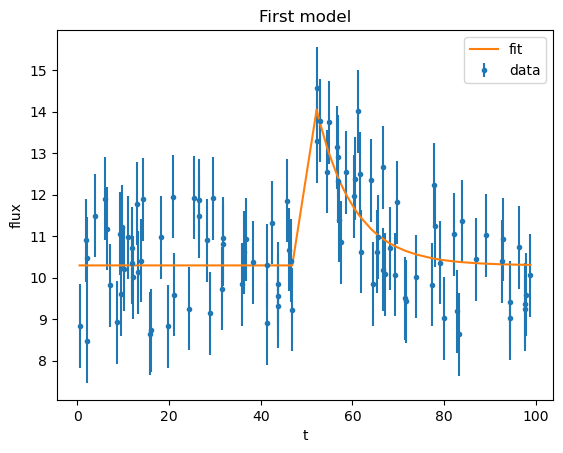

In [9]:
plt.errorbar(data[:,0],data[:,1],data[:,2],fmt='.',label='data')
plt.xlabel('t')
plt.ylabel('flux')
plt.title('First model')
plt.plot(data[:,0], model_1(medians,data[:,0]),label='fit')
plt.legend()
plt.show()

## Model 2: gaussian profile

In [10]:
ndim = 4

# "Static" nested sampling.
sampler2 = dynesty.NestedSampler(log_likelihood_2, prior_2, ndim=ndim, logl_args=[data[:,0],data[:,1],data[:,2]])
sampler2.run_nested()
sresults2 = sampler2.results

4050it [00:19, 24.05it/s, bound: 59 | nc: 198 | ncall: 62668 | eff(%):  6.463 | loglstar:   -inf < -178.132 <    inf | logz: -185.442 +/-  0.110 | dlogz: 27.691 >  0.509]    C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4298it [00:24, 23.89it/s, bound: 80 | nc: 257 | ncall: 78322 | eff(%):  5.488 | loglstar:   -inf < -175.529 <    inf | logz: -184.851 +/-  0.116 | dlogz: 27.097 >  0.509]C:\Users\giuli\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are usi

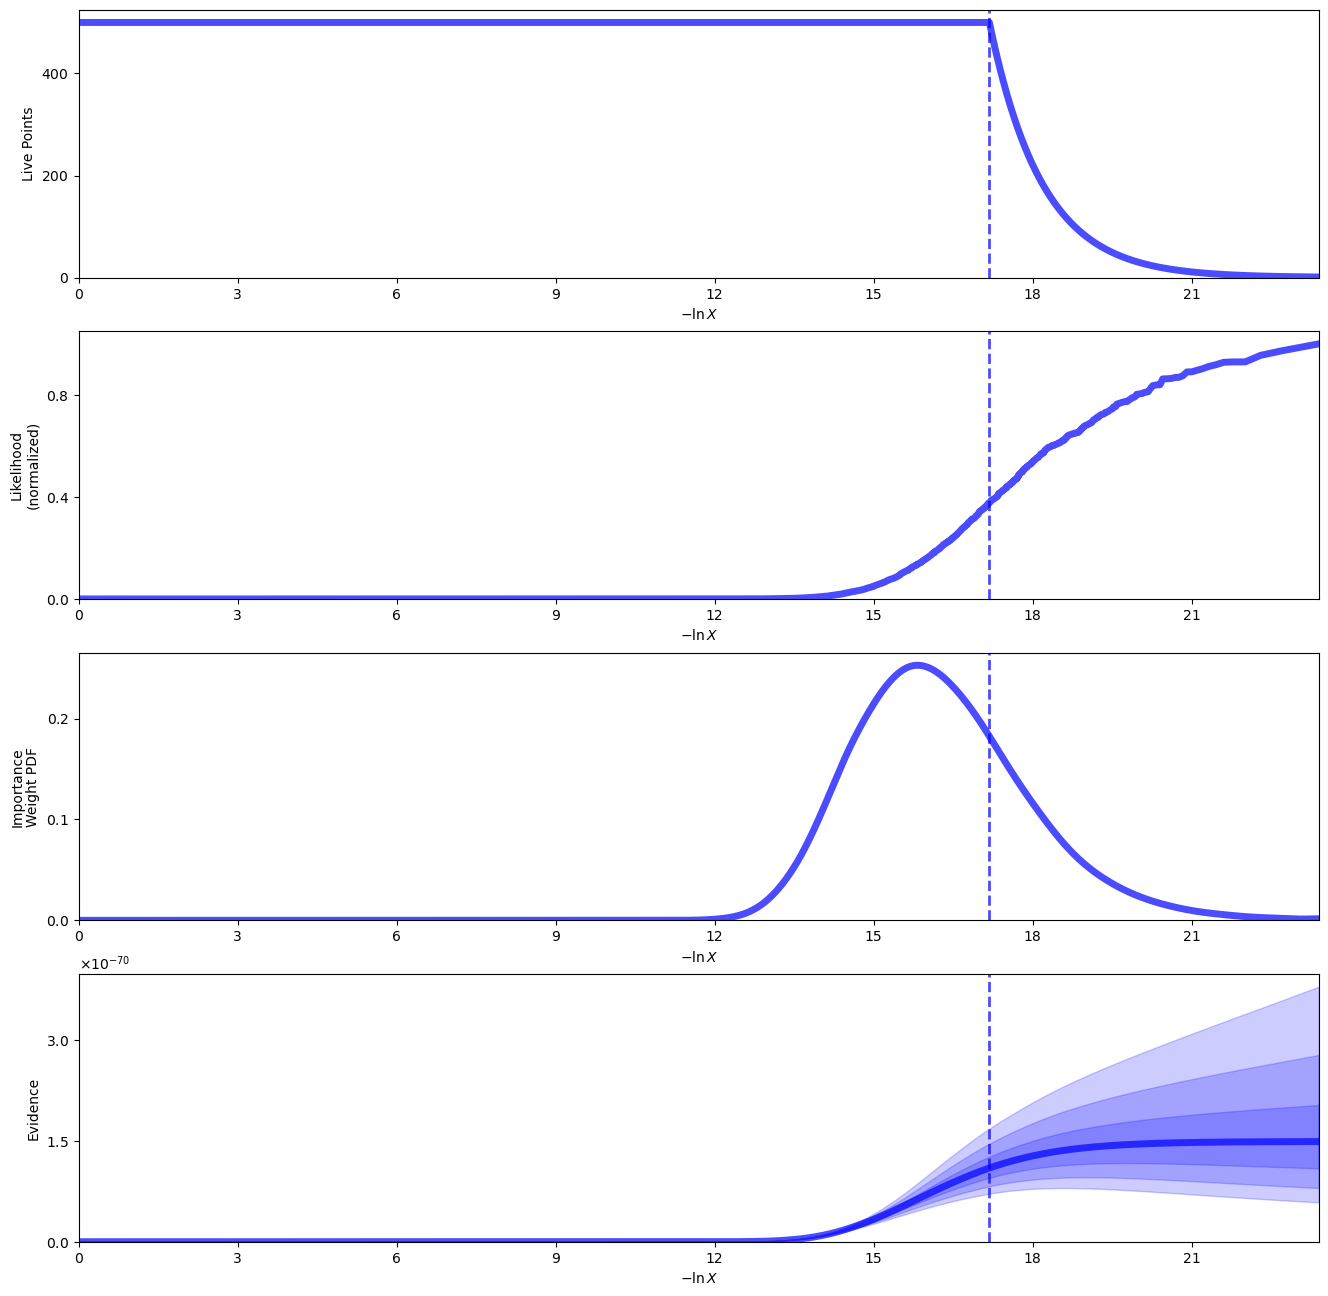

In [11]:
rfig, raxes = dyplot.runplot(sresults2)

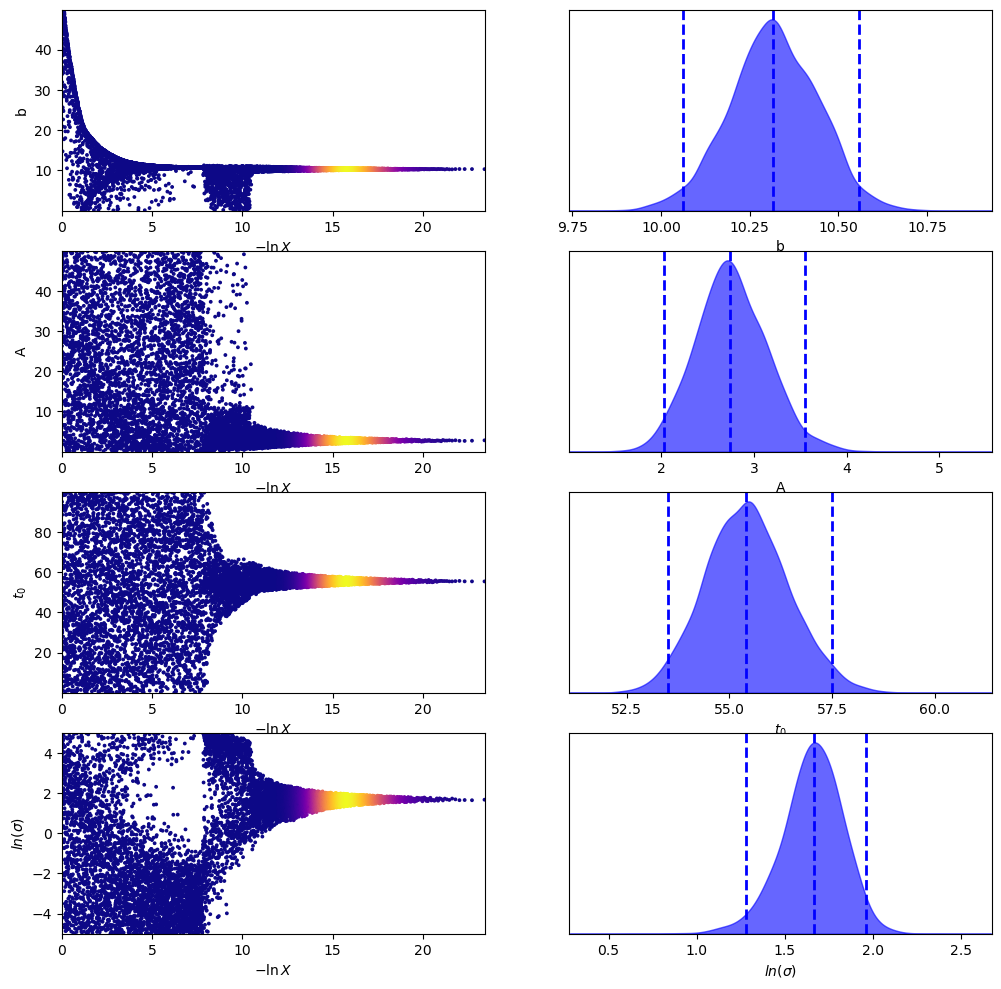

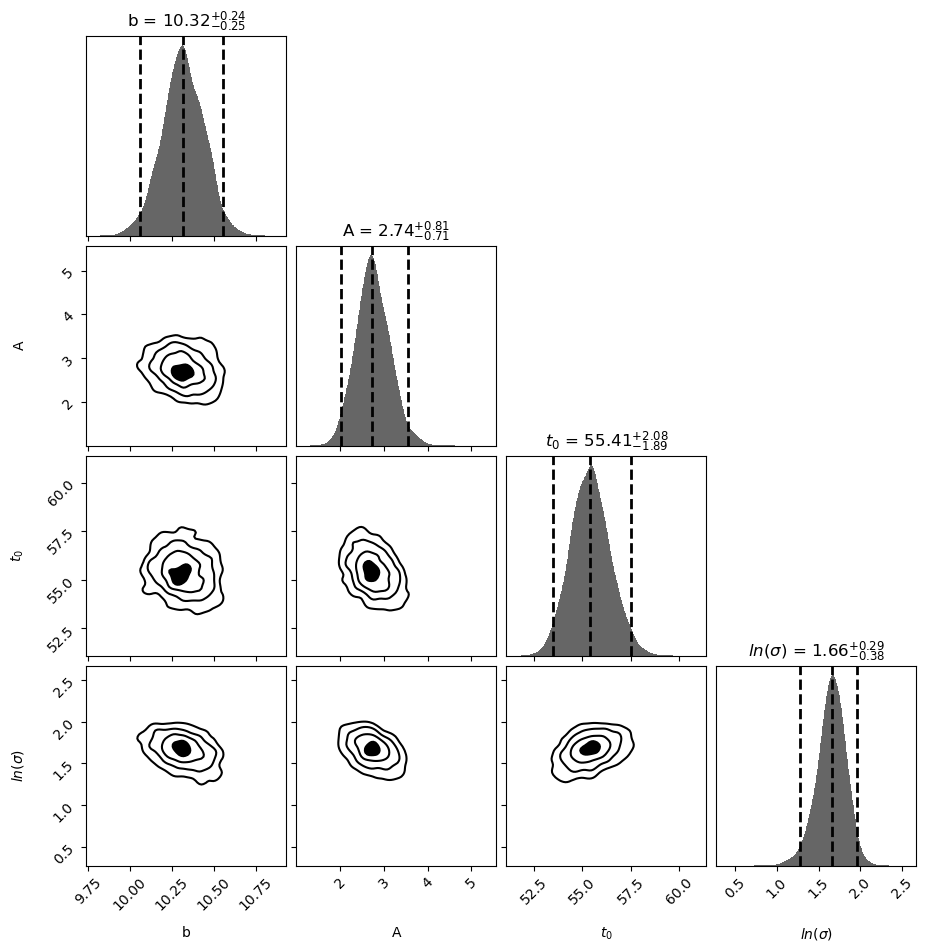

In [16]:
labels = ['b','A',r"$t_0$",r"$ln(\sigma)$"]
tfig, taxes = dyplot.traceplot(sresults2, labels=labels)
cfig, caxes = dyplot.cornerplot(sresults2, show_titles=True, labels=labels)

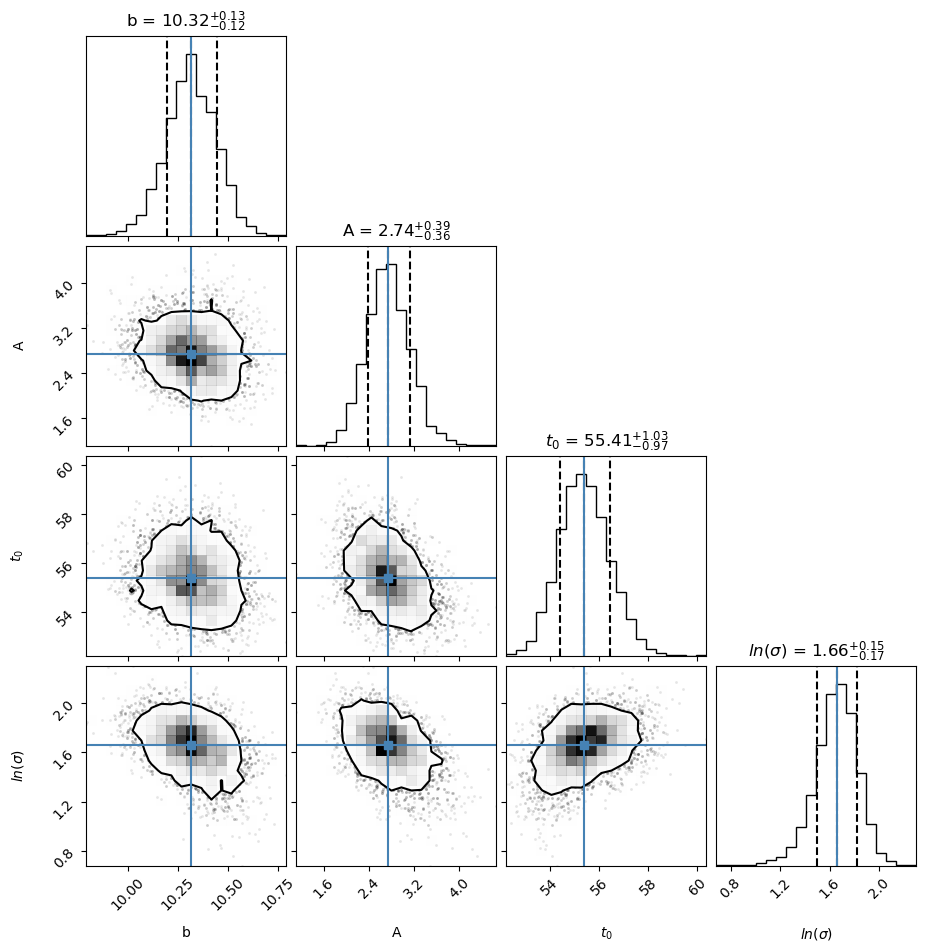

In [17]:
 #Resample weighted samples
weights2 = np.exp(sresults2.logwt - sresults2.logz[-1])
samples2 = sresults2.samples
samples_equal2 = dyfunc.resample_equal(samples2, weights2)

medians2 = np.median(samples_equal2,0)
fig = corner.corner(samples_equal2, levels=[0.9],labels=labels,
                    truths=medians2,show_titles=True,quantiles=[0.16,0.5,0.84])

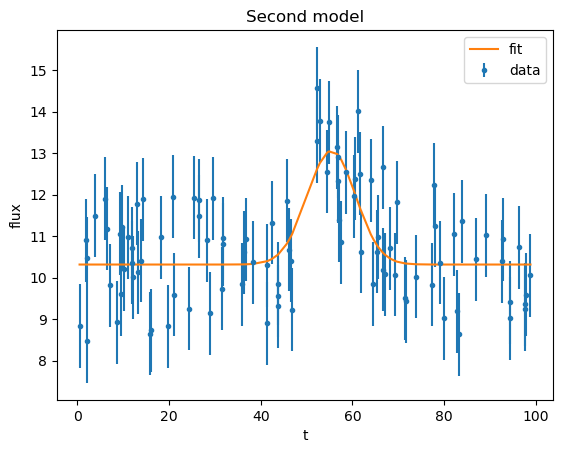

In [14]:
plt.errorbar(data[:,0],data[:,1],data[:,2],fmt='.',label='data')
plt.xlabel('t')
plt.ylabel('flux')
plt.title('Second model')
plt.plot(data[:,0], model_2(medians2,data[:,0]),label='fit')
plt.legend()
plt.show()

## Model comparison

Now we want to compare the two models: in order to do this, we compute Bayes' factor $B_{21}$, which is given by the ratio between the evidence of the second model and the evidence of the first model. We only need to compute $B_{21}$ to compare the two models since we took the same priors for both models. \
We use Jeffrey's scale to decide which model si preferred.

In [21]:
b = np.exp(sresults.logz[-1])/np.exp(sresults2.logz[-1])
print('Bayes factor = ', b)
if b>100:
    print('The first model is highly preferred')
else:
    print('The second model is preferred')

Bayes factor =  287.83127012387536
The first model is highly preferred
